# Visualisations

Accordion(children=(VBox(children=(Text(value=''), Button(description='Get discography', style=ButtonStyle()))…

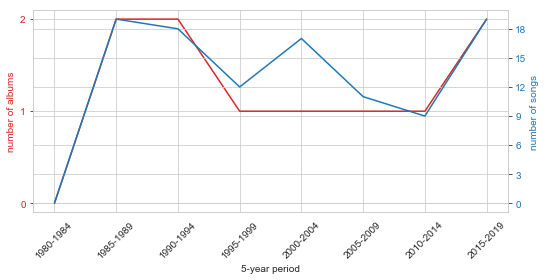

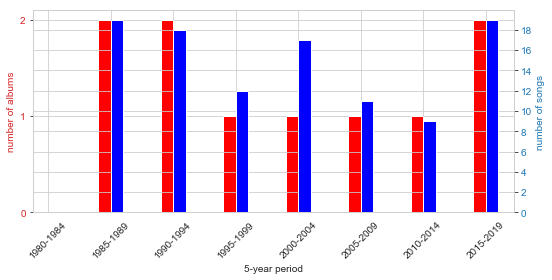

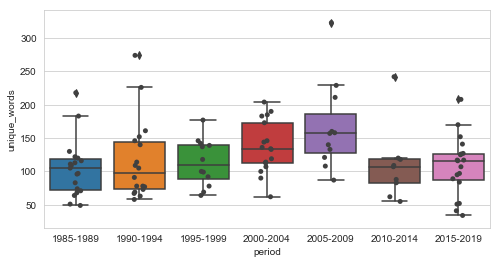

In [1]:
from UI.plots import plots as plots
plots()